In [1]:
%ls *.npy

model1_save.npy                  modelco2_3_layer_tanh_save5.npy
model1_update_save.npy           modelco2_3_layer_tanh_save6.npy
model_save.npy                   modelco2_relu_save.npy
modelco2_3_layer_tanh_save.npy   modelco2_tanh_save.npy
modelco2_3_layer_tanh_save1.npy  modelco2_tanhrelucos1_save.npy
modelco2_3_layer_tanh_save2.npy  modelco2_tanhrelucos2_save.npy
modelco2_3_layer_tanh_save3.npy  modelco2_tanhrelucos_save.npy
modelco2_3_layer_tanh_save4.npy


In [2]:
%ls SPK*.py

SPKernel.py        SPKernel3_tanh.py  SPKernel_tanh.py


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd
import numpy as np
#import autograd.numpy as np   # Thinly-wrapped version of Numpy
#from autograd import grad

import GPy
from GPy.kern import Kern
from GPy import Param, Model

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_openml

In [4]:
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data.iloc[:, 0]
    m = ml_data.data.iloc[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

In [5]:
# load dataset
x, y = load_mauna_loa_atmospheric_co2()

from sklearn import preprocessing
import random

random.seed(23)

idx = random.sample(range(len(x)), 50)

x_new = (x - min(x))/(max(x)-min(x))

scaler = preprocessing.StandardScaler().fit(y.reshape(-1,1))

y_new = scaler.transform(y.reshape(-1,1))


#train_gx = x_new[idx][:,None]
#train_gy = y_new[idx] + 0.0001 * np.random.normal(0,1,50)[:,None]

train_x = x_new[:200][:,None]
train_y = y_new[:200]

test_x = x_new[200:][:,None]
test_y = y_new[200:]

In [6]:
N = 5

w_net_g = np.random.normal(0,1,size=(N*4,1))

w_net_h = np.random.normal(0,1,size=(N*4,1))

num_cheap1 = 37

num_cheap2 = 23

x_g = np.linspace(0,1,num_cheap1)[:,None]

x_h = np.linspace(0,1,num_cheap2)[:,None]

In [7]:
from SPKernel3_tanh import *
from SPKernel_tanh import *

K = SPKernel3(input_dim = 1, std1=1., l1=1., std2=1., l2 = 1., std3 = 1., l3 = 1., Xg = x_g, w_net_g = w_net_g,
              Xh = x_h, w_net_h = w_net_h)

In [8]:
m1 = GPy.models.GPRegression(train_x, train_y, K, noise_var = 0.0001, initialize=False)
m1.update_model(False) # do not call the underlying expensive algebra on load
m1.initialize_parameter() # Initialize the parameters (connect the parameters up)
m1[:] = np.load('modelco2_3_layer_tanh_save6.npy') # Load the parameters
m1.update_model(True)

print(m1)


Name : GP regression
Objective : -253.22765066055373
Number of Parameters : 47
Number of Optimization Parameters : 47
Updates : True
Parameters:
  GP_regression.                    |                  value  |  constraints  |  priors
  SPKernel3.std1                    |   -0.49052855361081166  |               |        
  SPKernel3.std2                    |    -0.8613995551164986  |               |        
  SPKernel3.std3                    |     2.5626678079135536  |               |        
  SPKernel3.l1                      |   0.014286638121836708  |               |        
  SPKernel3.l2                      |     1.2055335628067236  |               |        
  SPKernel3.l3                      |     0.4621351020208425  |               |        
  SPKernel3.g_m_network_parameters  |                (20, 1)  |               |        
  SPKernel3.h_m_network_parameters  |                (20, 1)  |               |        
  Gaussian_noise.variance           |  0.0001496779532000347  

 /Users/felix/anaconda3/lib/python3.6/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


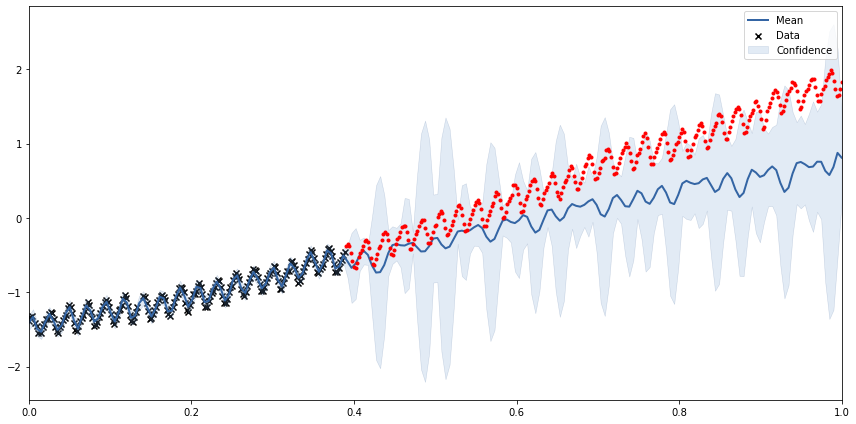

In [9]:
m1.plot([0,1],figsize=(12,6))
plt.plot(test_x,test_y,'r.')

In [10]:
x_plot = np.linspace(0,1,200)[:,None]

mu3, var3 = m1.predict(x_plot)

In [11]:
def nn(w, x):
    N = 5
    w1 = w[:N]
    b1 = w[N:2*N]
    w2 = w[2*N:3*N]
    b2 = w[3*N:]
    return np.sum(w2*np.tanh(w1*x+b1)+b2)
    #return np.sum(w2*np.maximum(0,w1*x+b1)+b2)
        
def g_values(w, X):
    tmp_f = lambda _x: nn(w,_x)
    return np.array(list(map(tmp_f, X))).reshape(-1,1)

In [12]:
h_values = g_values(m1.SPKernel3.h_m_network_parameters.values, x_h)

In [13]:
N = 5

def dg_dw(w, x):
    tmp1 = w[2] * x * (1-np.tanh(w[0]*x+w[1])**2)
    tmp2 = w[2] * (1-np.tanh(w[0]*x+w[1])**2)
    tmp3 = np.tanh(w[0]*x+w[1])
    tmp4 = np.ones((tmp1.shape[0],1))
    return np.hstack((tmp1,tmp2,tmp3,tmp4))

class MFRBF_grad(Kern):
    
    def __init__(self, input_dim, std1=1., lengthscale1=1., std2=1., lengthscale2=1., Xg=None, w_net=None, active_dims=None):
        super(MFRBF_grad, self).__init__(input_dim, active_dims, 'MFRBF_grad')
        self.std1 = Param('std1', std1)
        self.std2 = Param('std2', std2)
        self.lengthscale1 = Param('lengthscale1', lengthscale1)
        self.lengthscale2 = Param('lengthscale2', lengthscale2)
        self.Xg = Xg
        #self.g = g
        #self.link_parameters(self.std1, self.std2, self.lengthscale1, self.lengthscale2)
        self.w_net = Param('network parameters', w_net)
        self.link_parameters(self.std1, self.std2, self.lengthscale1, self.lengthscale2, self.w_net)
        
    def parameters_changed(self):
        pass
    
    def _neural_network(self, x):
        #N = 5
        w1 = self.w_net.values[:N]
        b1 = self.w_net.values[N:2*N]
        w2 = self.w_net.values[2*N:3*N]
        b2 = self.w_net.values[3*N:]
        return np.sum(w2*np.tanh(w1*x+b1)+b2)
        
    def _compute_g_values(self, X):
        tmp_f = lambda _x: self._neural_network(_x)
        return np.array(list(map(tmp_f, X))).reshape(-1,1)
        
    def _compute_grad_net(self, X):
        g_out = []
        for i in range(N):
            w_tmp = self.w_net.values[i::N]
            tmp_g = dg_dw(w_tmp, X)
            g_out.append(tmp_g)
        return np.array(g_out)
        
    def K(self, X, X2):
        #help(self.g)
        #print(self.g.values)
        values = self._compute_g_values(self.Xg)
        K1 = GPy.kern.RBF(input_dim=self.input_dim,variance=self.std1**2,lengthscale=self.lengthscale1)
        m1 = GPy.models.GPRegression(self.Xg, values, K1, noise_var = 0.0001)
        
        if X2 is None:
            mu, v = m1.predict(X, full_cov = True)

            dmu2 = euclidean_distances(mu,squared=True)
            cxx = np.repeat(v.diagonal(), v.shape[0]).reshape(v.shape[0], v.shape[1])
            cyy = np.transpose(cxx)
            delta2 = cxx + cyy - 2.*v
            delta2 = delta2 + self.lengthscale2**2*np.ones((v.shape[0],v.shape[0]))

            mat_exp = np.exp((-0.5)*np.divide(dmu2,delta2))
            mat_sqrt = delta2/self.lengthscale2**2
            mat_sqrt = self.std2**2 * np.power(mat_sqrt, -0.5)

            m_eff = np.multiply(mat_sqrt, mat_exp)
        else:
            X_new = np.vstack((X,X2))
            mu, v = m1.predict(X_new, full_cov=True)
            m_eff = np.zeros((X.shape[0],X2.shape[0]))
            L1 = X.shape[0]
            L2 = X2.shape[0]

            dmu2 = euclidean_distances(mu[:L1],mu[L1:],squared=True)
            diag1 = v.diagonal()[:L1]
            diag2 = v.diagonal()[L1:]

            # directly generate matrix representing cxx+cyy-2cxy 
            cxx = np.repeat(diag1, L2).reshape(L1,L2)
            cyy = np.repeat(diag2, L1).reshape(L2, L1)
            cyy = np.transpose(cyy)

            delta2 = cxx + cyy - 2.* v[:L1, L1:]
            delta2 = delta2 + self.lengthscale2**2 * np.ones((L1,L2))

            mat_exp = np.exp((-0.5)*np.divide(dmu2,delta2))
            mat_sqrt = delta2/self.lengthscale2**2
            mat_sqrt = self.std2**2 * np.power(mat_sqrt, -0.5)

            m_eff = np.multiply(mat_sqrt, mat_exp)
            
        return m_eff
    
    def Kdiag(self,X):
        return self.std2**2*np.ones(len(X))
    
    # derivative of rbf(x1,x2) with respect to lengthscale1
    def _dKdl(self,X, X2):
        if X2 is None:
            x=X.reshape(-1,1)
            tmpd2 = self.lengthscale1**(-3) * euclidean_distances(x,squared=True)
            tmprbf = self.std1**2 * rbf_kernel(x, gamma = 0.5*self.lengthscale1**(-2))
            return np.multiply(tmprbf, tmpd2)
        else:
            x=X.reshape(-1,1)
            y=X2.reshape(-1,1)
            tmpd2 = self.lengthscale1**(-3)*euclidean_distances(x,y,squared=True)
            tmprbf = self.std1**2 * rbf_kernel(x, y, gamma = 0.5*self.lengthscale1**(-2))
            return np.multiply(tmprbf, tmpd2)
        
    def update_gradients_full(self, dL_dK, X, X2):
        if X2 is None: X2 = X
        
        Kg = self.std1**2 * rbf_kernel(self.Xg, gamma = 0.5*self.lengthscale1**(-2))
        Kg += 0.00001 * np.identity(Kg.shape[0])
        Kg_inv = inv(Kg)
        
        Kxg = self.std1**2 * rbf_kernel(X, self.Xg, gamma = 0.5*self.lengthscale1**(-2))
        Kxx = self.std1**2 * rbf_kernel(X, gamma = 0.5*self.lengthscale1**(-2))

        values = self._compute_g_values(self.Xg)
        
        alpha = np.matmul(Kg_inv, values)
        Q = np.matmul(Kxg,Kg_inv)
        mu = np.matmul(Kxg, alpha)
        v = Kxx - np.matmul(np.matmul(Q, Kg), np.transpose(Q))

        dmu2 = euclidean_distances(mu,squared=True)
        cxx = np.repeat(v.diagonal(), v.shape[0]).reshape(v.shape[0], v.shape[1])
        cyy = np.transpose(cxx)
        delta1 = cxx + cyy - 2.*v
        delta2 = delta1 + self.lengthscale2**2*np.ones((v.shape[0],v.shape[0]))

        dmu1 = mu.reshape(-1,1) - mu.reshape(1,-1)

        mat_exp = np.exp((-0.5)*np.divide(dmu2,delta2))
        mat_sqrt = delta2/self.lengthscale2**2
        mat_sqrt = self.std2**2 * np.power(mat_sqrt, -0.5)
        m_eff = np.multiply(mat_sqrt, mat_exp)

        dKdmuxy = np.multiply(m_eff, np.divide((-1.)*dmu1,delta2))

        dKddelta2 = -0.5 * np.divide(np.ones((v.shape[0],v.shape[0])),delta2)
        dKddelta2 = dKddelta2 + 0.5*np.divide(dmu2, np.power(delta2, 2))
        dKddelta2 = np.multiply(m_eff, dKddelta2)

        dmudl = np.matmul(self._dKdl(X,self.Xg), alpha) 
        dmudl -= np.matmul(Q, np.matmul(self._dKdl(self.Xg, None),alpha))
        dmuxydl = dmudl.reshape(-1,1) - dmudl.reshape(1,-1)

        ddelta2dl = self._dKdl(X,None) - np.matmul(self._dKdl(X,self.Xg), np.transpose(Q))
        ddelta2dl += np.matmul(np.matmul(Q, self._dKdl(self.Xg, None)), np.transpose(Q))
        ddelta2dl -= np.matmul(Q, self._dKdl(self.Xg, X))

        dstd1 = 2. * delta2 / self.std1
        dstd1 = np.multiply(dKddelta2, dstd1)
        
        dl1 = np.multiply(dKdmuxy, dmuxydl) 
        dl1 += np.multiply(dKddelta2, ddelta2dl)

        dstd2 = 2*m_eff/self.std2

        dl2_1 = np.divide(delta1,delta2)/self.lengthscale2
        dl2_2 = np.divide(dmu2,np.power(delta2,2))*self.lengthscale2
        dl2 = np.multiply(m_eff, dl2_1+dl2_2)

        self.std1.gradient = np.sum(dstd1*dL_dK)
        self.std2.gradient = np.sum(dstd2*dL_dK)
        self.lengthscale2.gradient = np.sum(dl2*dL_dK)
        self.lengthscale1.gradient = np.sum(dl1*dL_dK)
        
        #grad_nn = self._compute_grad_net(Xg)
        
        #for i in range(len(self.w_net.values)):
        #    for j in range(len(self.w_net.values[i])):
                
        
        #for w in self.w_net.values:
        
        #dgg = np.zeros((self.g.values.shape[0],1))
        
        gg_net = self._compute_grad_net(self.Xg)
        
        for i in range(N):
            
            tmp_1 = np.matmul(Q,gg_net[i][:,0])
            tmp_w1 = tmp_1.reshape(-1,1) - tmp_1.reshape(1,-1)
            tmp_w1 = np.multiply(dKdmuxy, tmp_w1)
            self.w_net[i].gradient = np.sum(tmp_w1*dL_dK)
            
            tmp_2 = np.matmul(Q,gg_net[i][:,1])
            tmp_b1 = tmp_2.reshape(-1,1) - tmp_2.reshape(1,-1)
            tmp_b1 = np.multiply(dKdmuxy, tmp_b1)
            self.w_net[i+N].gradient = np.sum(tmp_b1*dL_dK)
            
            tmp_3 = np.matmul(Q,gg_net[i][:,2])
            tmp_w2 = tmp_3.reshape(-1,1) - tmp_3.reshape(1,-1)
            tmp_w2 = np.multiply(dKdmuxy, tmp_w2)
            self.w_net[i+N*2].gradient = np.sum(tmp_w2*dL_dK)
            
            tmp_4 = np.matmul(Q,gg_net[i][:,3])
            tmp_b2 = tmp_4.reshape(-1,1) - tmp_4.reshape(1,-1)
            tmp_b2 = np.multiply(dKdmuxy, tmp_b2)
            self.w_net[i+N*3].gradient = np.sum(tmp_b2*dL_dK)
        #    tmp_t = Q[:,i].reshape(-1,1)-Q[:,i].reshape(1,-1)
        #    dg = np.multiply(dKdmuxy,tmp_t)
        #    dgg[i] = np.sum(dg*dL_dK)
        
        
            
        #self.w_net.gradient = np.sum(dg*dL_dK)
        
    def update_gradients_diag(self, dL_dKdiag, X):
        self.std2.gradient = 2.*slef.std2*np.sum(dL_dKdiag)
        #self.std2.gradient = np.sum(dL_dKdiag)
        
    def gradients_X(self,dL_dK,X,X2):
        if X2 is None: X2 = X
        pass
    
    def gradients_X_diag(self,dL_dKdiag,X):
        pass
            

In [14]:
K2 = MFRBF_grad(input_dim = 1, 
                std1=m1.SPKernel3.std1, 
                lengthscale1=m1.SPKernel3.l1, 
                std2=m1.SPKernel3.std2, 
                lengthscale2 = m1.SPKernel3.l2, 
                Xg = x_g, 
                w_net = m1.SPKernel3.g_m_network_parameters.values)

In [15]:
m2 = GPy.models.GPRegression(x_h, h_values, K2, noise_var = 0.0001)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fbd27fbb8d0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fbd27fbb828>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fbd27fc8eb8>]}

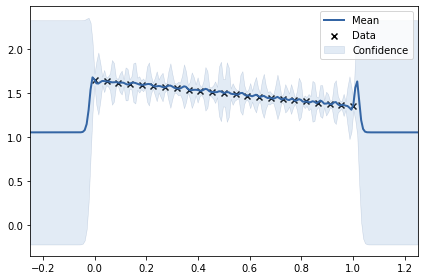

In [16]:
m2.plot()

In [17]:
mu2, var2 = m2.predict(x_plot)

In [18]:
g_values = g_values(m1.SPKernel3.g_m_network_parameters.values, x_g)

In [19]:
K3 = GPy.kern.RBF(input_dim=1,
                  variance=m1.SPKernel3.std1**2,
                  lengthscale=m1.SPKernel3.l1)

m3 = GPy.models.GPRegression(x_g, g_values, K3, noise_var = 0.0001)

{'dataplot': [<matplotlib.collections.PathCollection at 0x7fbd27002b38>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x7fbd24b30fd0>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x7fbd27002f98>]}

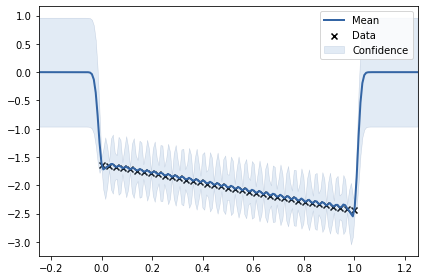

In [20]:
m3.plot()

In [21]:
mu1, var1 = m3.predict(x_plot)

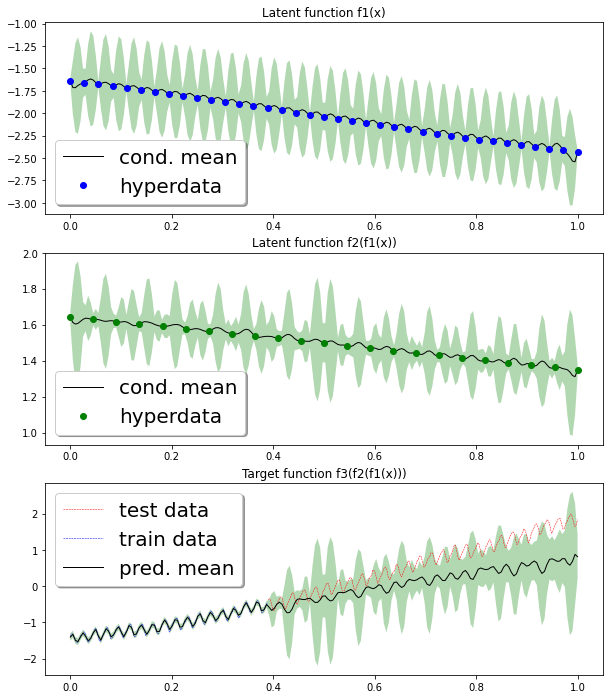

In [25]:
f = plt.figure(figsize=(10,12))
ax1 = f.add_subplot(311)
ax2 = f.add_subplot(312)
ax3 = f.add_subplot(313)

#plt.subplot(3, 1, 1)
#ax1.title('g(x)')
ax1.set_title('Latent function f1(x)')
ax1.plot(x_plot, mu1,'k-',linewidth=1)
ax1.plot(x_g, g_values,'bo')
#f3_ax33.plot(x_new,y_new,'b--',linewidth=0.5)
ax1.fill_between(np.array(x_plot).flatten(),
                     np.array(mu1+1.96*np.sqrt(var1)).flatten(),
                     np.array(mu1-1.96*np.sqrt(var1)).flatten(),
                     facecolor='g',alpha=0.3)
ax1.legend(('cond. mean', 'hyperdata'), loc='lower left', shadow=True, fontsize=20)
#ax1.text(0.0, -2.5, "activation unit = tanh", size=16)



#plt.subplot(3, 1, 2)
ax2.set_title('Latent function f2(f1(x))')
ax2.plot(x_plot, mu2,'k-',linewidth=1)
ax2.plot(x_h, h_values,'go')
#f3_ax33.plot(x_new,y_new,'b--',linewidth=0.5)
ax2.fill_between(np.array(x_plot).flatten(),
                     np.array(mu2+1.96*np.sqrt(var2)).flatten(),
                     np.array(mu2-1.96*np.sqrt(var2)).flatten(),
                     facecolor='g',alpha=0.3)
ax2.legend(('cond. mean', 'hyperdata'), loc='lower left', shadow=True, fontsize=20)
#ax2.text(0.0, 1.2, "activation unit = tanh", size=16)

#plt.subplot(3, 1, 3)
ax3.set_title('Target function f3(f2(f1(x)))')
ax3.plot(test_x,test_y,'r--', linewidth=0.5)
ax3.plot(train_x, train_y, 'b--', linewidth=0.5)
ax3.plot(x_plot, mu3,'k-',linewidth=1)
#plt.plot(x_h, h_values,'go')
#f3_ax33.plot(x_new,y_new,'b--',linewidth=0.5)
ax3.fill_between(np.array(x_plot).flatten(),
                     np.array(mu3+1.96*np.sqrt(var3)).flatten(),
                     np.array(mu3-1.96*np.sqrt(var3)).flatten(),
                     facecolor='g',alpha=0.3)
ax3.legend(('test data', 'train data', 'pred. mean'), loc='upper left', shadow=True,  fontsize=20)


f.savefig('demo_co2_3layerDGP_good1.pdf', bbox_inches='tight')
#m1.plot()